In [28]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
data = pd.read_csv('data.csv') #Three stocks (R,X_s,X_b) Without predictors

In [37]:
s= data.iloc[1,2:4].values.reshape(1,2)
print(s)
# print(A)
# random.choice(A)
# A.size
s[0][0]

[[0.036518667000000005 0.0070776669999999993]]


0.01

In [33]:
#Initialize Neural Network and set-up the placeholders
tf.reset_default_graph()
NN_input = tf.placeholder(shape=[1,2],dtype=tf.float32)
NN_weights = tf.Variable(tf.random_uniform([2,101],0,0.01))
Q_FA = tf.matmul(NN_input,NN_weights)
A_Max = tf.argmax(Q_FA,1)

# Calculate loss for the NN from the Q values
Q_Next = tf.placeholder(shape=[1,101],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(Q_Next - Q_FA))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

#Define Action Matrix (Now discrete case) 
A = np.arange(0,1.01,0.01) # portfolio weights of stocks (1-weight) is the weight in the bonds
# A = np.matrix([[0.0, 0.0, 0.0],[0.1,0.1,0.1],[0.2,0.2,0.2],[-0.1,0.0,0.0],[-0.2,0.0,0.0],[0.0,-0.1,0.0],[0.0,0.0,-0.1],[0.0,-0.2,0.0],[0.0,0.0,-0.2],[-0.2,-0.2,-0.2]])

In [57]:
# initialize
init = tf.global_variables_initializer()
gamma = 1 
epsilon = 0.1
train_data = 241 # also an expanding window
jList = []
TWlist = []

with tf.Session() as sess:
    for i in range(train_data):
        #Initilization
        sess.run(init) # initialize the 
        s = data.iloc[i,2:4].values.reshape(1,2)
        rAll = 0
        j = 0
        rTot = 0
        
        #Training of the Q-Network for the data available(with Neural Nets) 
        while j < 120:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a_int,allQ = sess.run([A_Max,Q_FA],feed_dict={NN_input:s})
            a = A[a_int-1]  # -1 because the output neurons are labeled 1 till 101 and it will be an index
            if np.random.rand(1) < epsilon:
                a = random.choice(A)
                
            #Get new state and reward from environment
            s1 = data.iloc[j+i,2:4].values.reshape(1,2)
            r = (a*s1[0][0] + (1-a)*s1[0][1]) #reward: this is now the wealth gained from this step, but could be other rewards like utility
            Q = sess.run(Q_FA,feed_dict={NN_input:s1})
            
            #Obtain maxQ' and set our target value for chosen action.
            Q1 = np.max(Q)
            targetQ = allQ
            targetQ[0,a_int] = r + gamma*Q1
 
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,NN_input],feed_dict={NN_input:s,Q_Next:targetQ})
            rAll += r
            s = s1
            if j > 200:
                # increase the random actions over time in order to improve exploitation rather than exploration
                # only increase exploitation when a good action has been found (otherwise one exploits a bad solution)
                e = 1./((i/50) + 10)
                break
            rTot += r
            TW = np.exp(rTot)
        jList.append(j)
        TWList.append(TW)



Average reward per episode: [ 1.63856748]


1.6385674846369382

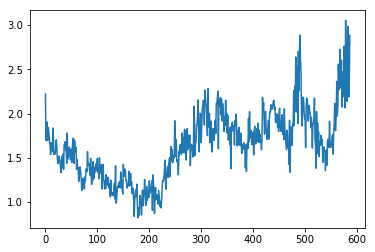

In [58]:
plt.plot(rList)
np.mean(rList)

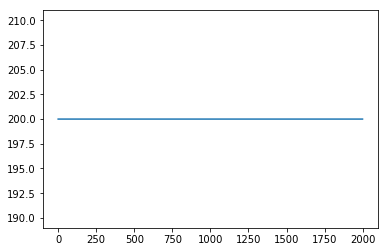

In [44]:
plt.plot(jList)